# **StyleGAN-2 for feature extraction**
This notebook is based on that [GitHub](https://github.com/karray/stylegan2-pytorch/tree/master).

## **Install dependencies**

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-36b430e3-5bd0-5eb1-c17e-607faa40ff24)


In [ ]:
!ninja --version

/bin/bash: line 1: ninja: command not found


In [ ]:
!git clone https://github.com/karray/stylegan2-pytorch/

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 416 (delta 5), reused 7 (delta 5), pack-reused 407
Receiving objects: 100% (416/416), 122.53 MiB | 25.97 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [ ]:
import os
!pip install gdown --upgrade

if os.path.isdir("/content/drive/MyDrive/style-gan-2"):
    %cd "/content/drive/MyDrive/style-gan-2/stylegan2-pytorch"
elif os.path.isdir("/content/drive/"):
    %cd "/content/drive/MyDrive/"
    !mkdir style-gan-2
    %cd style-gan-2
    !git clone https://github.com/karray/stylegan2-pytorch/
    %cd stylegan2-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    #!gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU -O /content/drive/MyDrive/style-gan-2/stylegan2-ada-pytorch/pretrained/wikiart.pkl
else:
    !git clone https://github.com/karray/stylegan2-pytorch/
    %cd stylegan2-pytorch
    !mkdir downloads
    !mkdir datasets
    !mkdir pretrained
    %cd pretrained
    !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU
    %cd ../

In [ ]:
!pip uninstall jax jaxlib -y
!pip install "jax[cuda11_cudnn805]==0.3.10" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip uninstall torch torchvision -y
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install timm==0.4.12 ftfy==6.1.1 ninja==1.10.2 opensimplex
!pip install wandb

## **Library imports**

### *Solve minor errors in scripts*

In [ ]:
# to solve name conflict with Python modules
!mv /content/stylegan2-pytorch/distributed.py /content/stylegan2-pytorch/distributed_utils.py

mv: cannot stat '/content/stylegan2-pytorch/distributed.py': No such file or directory


In [ ]:
file_path = '/content/stylegan2-pytorch/non_leaking.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[7] = 'from distributed_utils import reduce_sum\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [ ]:
file_path = '/content/stylegan2-pytorch/non_leaking.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines[359] = '        op = torch._C._jit_get_operation("aten::grid_sampler_2d_backward")[0]\n'
lines[360] = '        grad_input, grad_grid = op(grad_output, input, grid, 0, 0, False, [True, True])\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

### *Imports*


In [ ]:
import sys
sys.path.append('/content/stylegan2-pytorch/')

In [ ]:
import math
import random
import functools
import operator
import argparse
import os
from os.path import join as ospj
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, autograd, optim
from torch.nn import functional as F
from torch.autograd import Function
from torch.utils import data
import torch.distributed as dist
from torchvision import transforms, utils
from torchvision.datasets import MNIST, CIFAR10, CIFAR100

from op import fused_leaky_relu, upfirdn2d, conv2d_gradfix
from model import Generator, Generator1, DiscriminatorMini, MappingNetwork, Encoder
from distributed_utils import get_rank, synchronize, reduce_loss_dict, reduce_sum, get_world_size
from op import conv2d_gradfix
from non_leaking import augment, AdaptiveAugment

import wandb

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


## **Training script**

In [ ]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)


def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()


def d_r1_loss(real_pred, real_img):
    with conv2d_gradfix.no_weight_gradients():
        grad_real, = autograd.grad(
            outputs=real_pred.sum(), inputs=real_img, create_graph=True
        )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty


def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss


def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    grad, = autograd.grad(
        outputs=(fake_img * noise).sum(), inputs=latents, create_graph=True
    )
    path_lengths = torch.sqrt(grad.pow(2).sum(2).mean(1))

    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)

    path_penalty = (path_lengths - path_mean).pow(2).mean()

    return path_penalty, path_mean.detach(), path_lengths


def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return [torch.randn(batch, latent_dim, device=device)]

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises


def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return make_noise(batch, latent_dim, 1, device)


def set_grad_none(model, targets):
    for n, p in model.named_parameters():
        if n in targets:
            p.grad = None


def train(args, loader, generator, discriminator,mapping, encoder, g_optim, d_optim, f_optim, e_optim, g_ema, debug_images, debug_z, debug_noise, device,
            sample_dir, working_dir):

    pbar = range(args.iter)

    if get_rank() == 0:
        pbar = tqdm(pbar, initial=args.start_iter, dynamic_ncols=True, smoothing=0.01)

    mean_path_length = 0

    d_loss_val = 0
    r1_loss = torch.tensor(0.0, device=device)
    g_loss_val = 0
    path_loss = torch.tensor(0.0, device=device)
    path_lengths = torch.tensor(0.0, device=device)
    mean_path_length_avg = 0
    loss_dict = {}

    if args.distributed:
        g_module = generator.module
        d_module = discriminator.module
        f_module = mapping.module
        e_module = encoder.module

    else:
        g_module = generator
        d_module = discriminator
        f_module = mapping
        e_module = encoder

    accum = 0.5 ** (32 / (10 * 1000))
    ada_aug_p = args.augment_p if args.augment_p > 0 else 0.0
    r_t_stat = 0

    if args.augment and args.augment_p == 0:
        ada_augment = AdaptiveAugment(args.ada_target, args.ada_length, 8, device)

    for idx in pbar:
        i = idx + args.start_iter

        if i > args.iter:
            print("Done!")
            break

        real_img = next(loader)
        real_img = real_img[0].to(device)

        requires_grad(generator, False)
        requires_grad(mapping, False)
        requires_grad(discriminator, True)
        requires_grad(encoder, True)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator([mapping(z) for z in noise])

        if args.augment:
            real_img_aug, _ = augment(real_img, ada_aug_p)
            fake_img, _ = augment(fake_img, ada_aug_p)

        else:
            real_img_aug = real_img

        fake_pred = discriminator(encoder(fake_img))
        real_pred = discriminator(encoder(real_img_aug))
        d_loss = d_logistic_loss(real_pred, fake_pred)

        loss_dict["d"] = d_loss
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        discriminator.zero_grad()
        encoder.zero_grad()
        d_loss.backward()
        d_optim.step()
        e_optim.step()

        if args.augment and args.augment_p == 0:
            ada_aug_p = ada_augment.tune(real_pred)
            r_t_stat = ada_augment.r_t_stat

        d_regularize = i % args.d_reg_every == 0

        if d_regularize:
            real_img.requires_grad = True

            if args.augment:
                real_img_aug, _ = augment(real_img, ada_aug_p)

            else:
                real_img_aug = real_img

            real_pred = discriminator(encoder(real_img_aug))
            r1_loss = d_r1_loss(real_pred, real_img)

            discriminator.zero_grad()
            encoder.zero_grad()
            (args.r1 / 2 * r1_loss * args.d_reg_every + 0 * real_pred[0]).backward()

            d_optim.step()
            e_optim.step()

        loss_dict["r1"] = r1_loss

        requires_grad(generator, True)
        requires_grad(mapping, True)
        requires_grad(discriminator, False)
        requires_grad(encoder, False)

        noise = mixing_noise(args.batch, args.latent, args.mixing, device)
        fake_img, _ = generator([mapping(z) for z in noise])

        if args.augment:
            fake_img, _ = augment(fake_img, ada_aug_p)

        fake_pred = discriminator(encoder(fake_img))
        g_loss = g_nonsaturating_loss(fake_pred)

        loss_dict["g"] = g_loss

        generator.zero_grad()
        mapping.zero_grad()
        g_loss.backward()
        g_optim.step()
        f_optim.step()

        g_regularize = i % args.g_reg_every == 0

        if g_regularize:
            path_batch_size = max(1, args.batch // args.path_batch_shrink)
            noise = mixing_noise(path_batch_size, args.latent, args.mixing, device)
            fake_img, latents = generator([mapping(z) for z in noise], return_latents=True)

            path_loss, mean_path_length, path_lengths = g_path_regularize(
                fake_img, latents, mean_path_length
            )

            generator.zero_grad()
            mapping.zero_grad()
            weighted_path_loss = args.path_regularize * args.g_reg_every * path_loss

            if args.path_batch_shrink:
                weighted_path_loss += 0 * fake_img[0, 0, 0, 0]

            weighted_path_loss.backward()

            g_optim.step()
            f_optim.step()

            mean_path_length_avg = (
                reduce_sum(mean_path_length).item() / get_world_size()
            )

        loss_dict["path"] = path_loss
        loss_dict["path_length"] = path_lengths.mean()

        requires_grad(generator, True)
        requires_grad(mapping, True)
        requires_grad(discriminator, False)
        requires_grad(encoder, True)

        w_z = mapping(torch.randn(args.batch, args.latent, device=device))
        fake_img, _ = generator([w_z])
        consitency_loss = (w_z - encoder(fake_img)).pow(2).mean()

        loss_dict["consitency_loss"] = g_loss

        generator.zero_grad()
        mapping.zero_grad()
        encoder.zero_grad()
        consitency_loss.backward()
        g_optim.step()
        f_optim.step()
        e_optim.step()

        accumulate(g_ema, g_module, accum)

        loss_reduced = reduce_loss_dict(loss_dict)

        d_loss_val = loss_reduced["d"].mean().item()
        g_loss_val = loss_reduced["g"].mean().item()
        r1_val = loss_reduced["r1"].mean().item()
        path_loss_val = loss_reduced["path"].mean().item()
        real_score_val = loss_reduced["real_score"].mean().item()
        fake_score_val = loss_reduced["fake_score"].mean().item()
        path_length_val = loss_reduced["path_length"].mean().item()
        w_consitency_loss = loss_reduced["consitency_loss"].mean().item()

        if get_rank() == 0:

            pbar.set_description(
                (
                    f"d: {d_loss_val:.4f}; g: {g_loss_val:.4f}; r1: {r1_val:.4f}; "
                    f"path: {path_loss_val:.4f}; mean path: {mean_path_length_avg:.4f}; "
                    f"augment: {ada_aug_p:.4f}"
                )
            )

            if (i+1) % 100 == 0:

                torch.save(
                    {
                        "g": g_module.state_dict(),
                        "d": d_module.state_dict(),
                        "f": f_module.state_dict(),
                        "e": e_module.state_dict(),
                        "g_ema": g_ema.state_dict(),
                        "g_optim": g_optim.state_dict(),
                        "d_optim": d_optim.state_dict(),
                        "f_optim": f_optim.state_dict(),
                        "e_optim": e_optim.state_dict(),
                        "args": args,
                        "ada_aug_p": ada_aug_p,
                    },
                    ospj(working_dir, f"checkpoint_last.pt"),
                )

                with torch.no_grad():
                    g_ema.eval()

                    debug_img = [debug_images]

                    # reconstruct real images
                    w = encoder(debug_images)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    # generate from noise
                    w = mapping(debug_z)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    # reconstruct from noise
                    w = encoder(images)
                    images, _ = g_ema([w], noise=debug_noise)
                    debug_img.append(images)

                    debug_img = torch.cat(debug_img, dim=0)

                    debug_img = debug_img.view(4, 8, 3, 32, 32)
                    debug_img = debug_img.permute(0, 3, 1, 4, 2)
                    debug_img = debug_img.reshape(4 * 32, 8 * 32, 3)

                    debug_img = debug_img.cpu().numpy()

                    plt.figure(figsize=(8, 8))
                    plt.imshow(debug_img)
                    plt.axis('off')
                    plt.show()

## **Define parameters**

In [ ]:
sys.argv = [
    'script_name', '--path', 'data', '--arch', 'stylegan2', '--iter', '10000',
    '--batch', '32', '--n_sample', '64', '--r1', '10', '--path_regularize', '2',
    '--path_batch_shrink', '2', '--d_reg_every', '16', '--g_reg_every', '4',
    '--mixing', '0.9', '--ckpt', 'None', '--lr', '0.002', '--channel_multiplier', '2',
    '--local_rank', '0', '--augment', '--augment_p', '0', '--ada_target', '0.6',
    '--ada_length', '500000', '--ada_every', '256', '--gpu', '0', '--name', 'experiment',
    '--run_name', 'run1'
]

## **Training loop**

In [ ]:
parser = argparse.ArgumentParser(description="StyleGAN2 trainer")

parser.add_argument("--path", type=str, default='data', help="path to save mnist dataset")
parser.add_argument('--arch', type=str, default='stylegan2', help='model architectures (stylegan2 | swagan)')
parser.add_argument(
    "--iter", type=int, default=800000, help="total training iterations"
)
parser.add_argument(
    "--batch", type=int, default=32, help="batch sizes for each gpus"
)
parser.add_argument(
    "--n_sample",
    type=int,
    default=64,
    help="number of the samples generated during training",
)
parser.add_argument(
    "--r1", type=float, default=10, help="weight of the r1 regularization"
)
parser.add_argument(
    "--path_regularize",
    type=float,
    default=2,
    help="weight of the path length regularization",
)
parser.add_argument(
    "--path_batch_shrink",
    type=int,
    default=2,
    help="batch size reducing factor for the path length regularization (reduce memory consumption)",
)
parser.add_argument(
    "--d_reg_every",
    type=int,
    default=16,
    help="interval of the applying r1 regularization",
)
parser.add_argument(
    "--g_reg_every",
    type=int,
    default=4,
    help="interval of the applying path length regularization",
)
parser.add_argument(
    "--mixing", type=float, default=0.9, help="probability of latent code mixing"
)
parser.add_argument(
    "--ckpt",
    type=str,
    default=None,
    help="path to the checkpoints to resume training",
)
parser.add_argument("--lr", type=float, default=0.002, help="learning rate")
parser.add_argument(
    "--channel_multiplier",
    type=int,
    default=2,
    help="channel multiplier factor for the model. config-f = 2, else = 1",
)
parser.add_argument(
    "--wandb", action="store_true", help="use weights and biases logging"
)
parser.add_argument(
    "--local_rank", type=int, default=0, help="local rank for distributed training"
)
parser.add_argument(
    "--augment", action="store_true", help="apply non leaking augmentation"
)
parser.add_argument(
    "--augment_p",
    type=float,
    default=0,
    help="probability of applying augmentation. 0 = use adaptive augmentation",
)
parser.add_argument(
    "--ada_target",
    type=float,
    default=0.6,
    help="target augmentation probability for adaptive augmentation",
)
parser.add_argument(
    "--ada_length",
    type=int,
    default=500 * 1000,
    help="target duraing to reach augmentation probability for adaptive augmentation",
)
parser.add_argument(
    "--ada_every",
    type=int,
    default=256,
    help="probability update interval of the adaptive augmentation",
)

parser.add_argument("--gpu", type=str, help="GPU ID")
parser.add_argument("--name", type=str, help="Experiment name")
parser.add_argument("--run_name", type=str, help="Run name")

args = parser.parse_args()

device = f'cuda:{args.gpu}'

n_gpu = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
args.distributed = n_gpu > 1

if args.distributed:
    torch.cuda.set_device(args.local_rank)
    torch.distributed.init_process_group(backend="nccl", init_method="env://")
    synchronize()

args.latent = 128
args.n_mlp = 8
args.size = 32

args.start_iter = 0

generator = Generator1(
    args.size, args.latent, channel_multiplier=args.channel_multiplier
).to(device)
mapping = MappingNetwork(args.latent, args.n_mlp,).to(device)
discriminator = DiscriminatorMini(args.latent).to(device)
encoder = Encoder(args.size, args.latent).to(device)
g_ema = Generator1(
    args.size, args.latent, channel_multiplier=args.channel_multiplier
).to(device)
g_ema.eval()
accumulate(g_ema, generator, 0)

g_reg_ratio = args.g_reg_every / (args.g_reg_every + 1)
d_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)

g_optim = optim.Adam(
    generator.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)
d_optim = optim.Adam(
    discriminator.parameters(),
    lr=args.lr * d_reg_ratio,
    betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
)
f_optim = optim.Adam(
    mapping.parameters(),
    lr=args.lr * g_reg_ratio,
    betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio),
)
e_optim = optim.Adam(
    encoder.parameters(),
    lr=args.lr * d_reg_ratio,
    betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio),
)

if args.ckpt != 'None':
    print("load model:", args.ckpt)

    ckpt = torch.load(args.ckpt)

    try:
        ckpt_name = os.path.basename(args.ckpt)
        args.start_iter = int(os.path.splitext(ckpt_name)[0])

    except ValueError:
        pass

    generator.load_state_dict(ckpt["g"])
    discriminator.load_state_dict(ckpt["d"])
    mapping.load_state_dict(ckpt["f"])
    encoder.load_state_dict(ckpt["e"])
    g_ema.load_state_dict(ckpt["g_ema"])

    g_optim.load_state_dict(ckpt["g_optim"])
    d_optim.load_state_dict(ckpt["d_optim"])
    f_optim.load_state_dict(ckpt["f_optim"])
    e_optim.load_state_dict(ckpt["e_optim"])

if args.distributed:
    generator = nn.parallel.DistributedDataParallel(
        generator,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    discriminator = nn.parallel.DistributedDataParallel(
        discriminator,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    mapping = nn.parallel.DistributedDataParallel(
        mapping,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

    encoder = nn.parallel.DistributedDataParallel(
        encoder,
        device_ids=[args.local_rank],
        output_device=args.local_rank,
        broadcast_buffers=False,
    )

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
])

dataset = CIFAR100(root=args.path, train=True, download=True, transform=transform)

loader = data.DataLoader(
    dataset,
    batch_size=args.batch,
    sampler=data_sampler(dataset, shuffle=True, distributed=args.distributed),
    drop_last=True,
)
loader = sample_data(loader)

debug_images = next(loader)[0][:8].to(device)
debug_noise = generator.make_noise()
debug_z = torch.randn(8, args.latent, device=device)

args.wandb = False
args.wandb


if get_rank() == 0 and wandb is not None and args.wandb:
    wandb.init(project=args.name)
    wandb.run.name = args.run_name
    wandb.run.save()

if not os.path.exists('results'):
    os.mkdir('results')
working_dir = ospj('results', f'{args.name}_{args.run_name}')
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

sample_dir = ospj(working_dir, 'samples')
if not os.path.exists(sample_dir):
    os.mkdir(sample_dir)

working_dir = working_dir

images = train(args, loader, generator, discriminator, mapping, encoder, g_optim, d_optim, f_optim, e_optim, g_ema, debug_images, debug_z, debug_noise, device,
        sample_dir, working_dir)

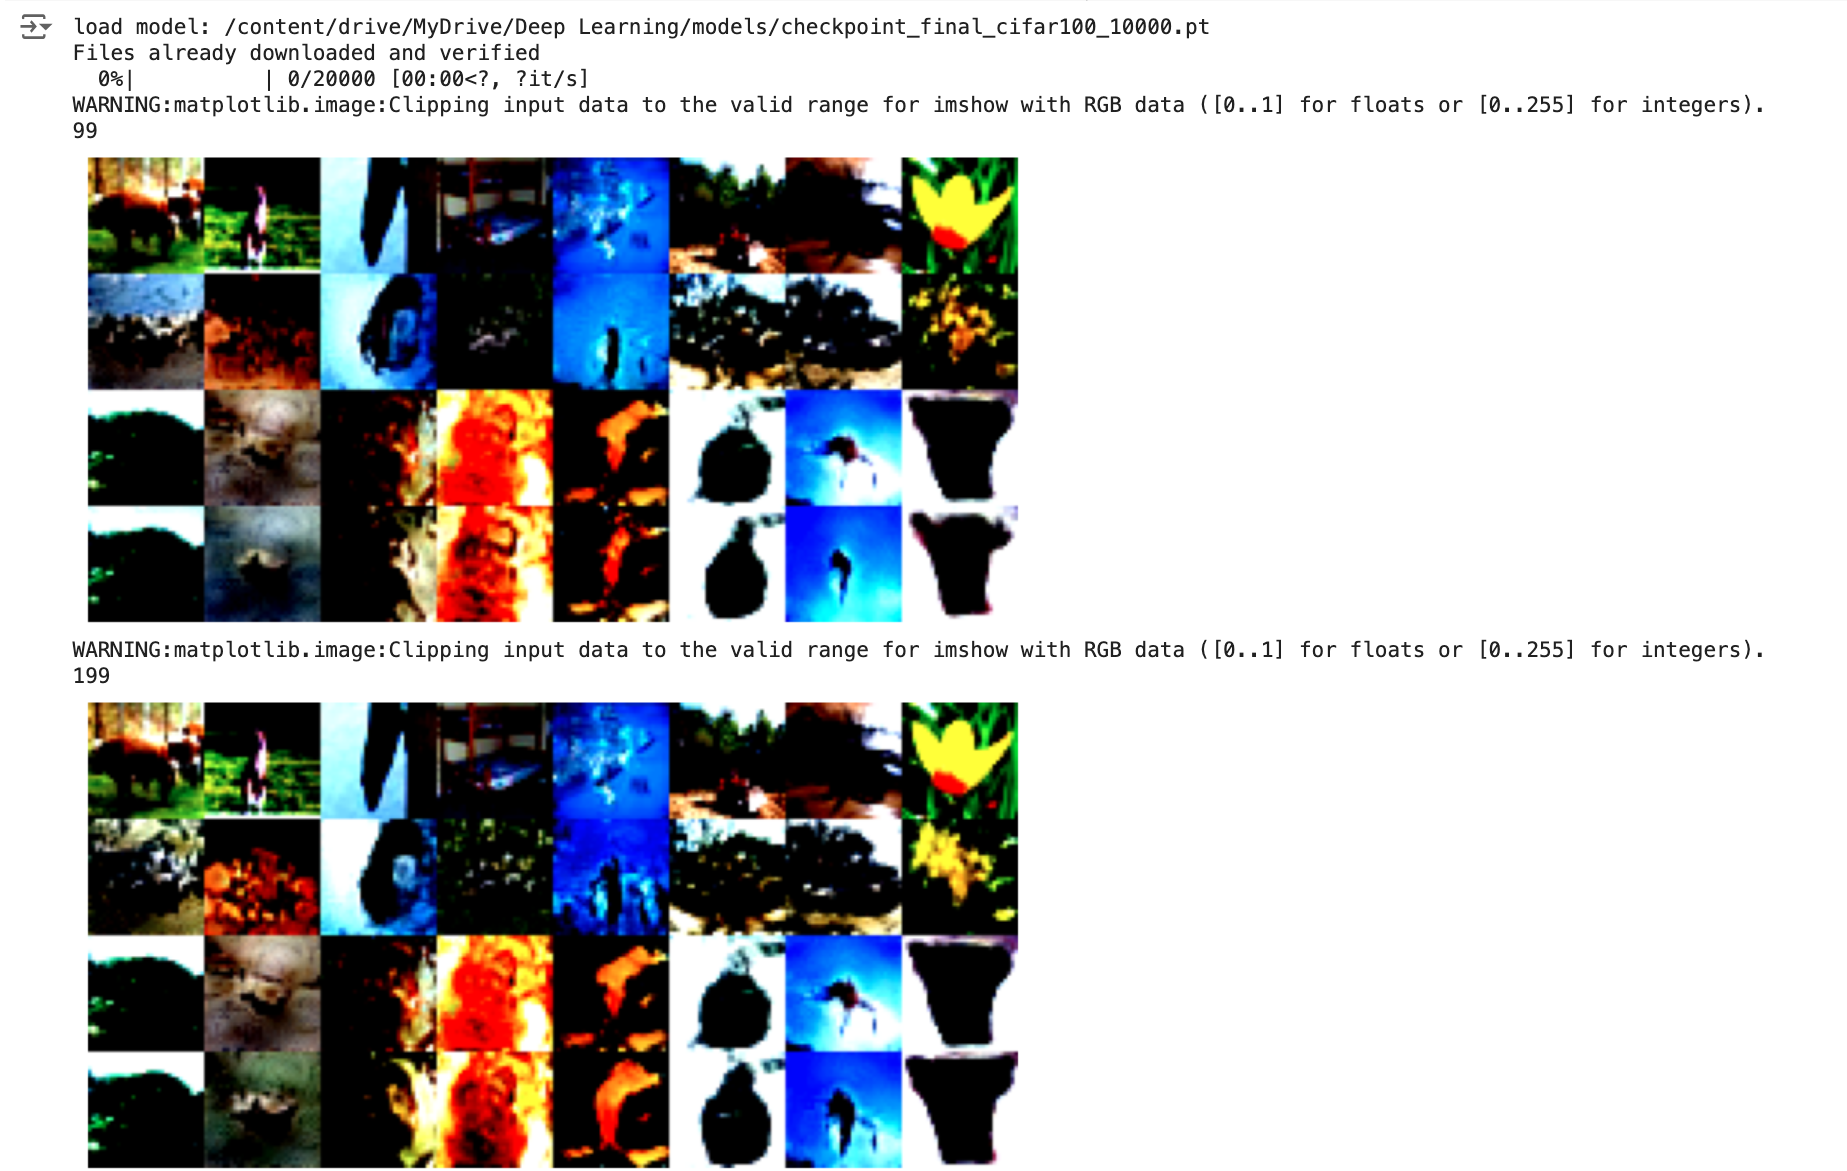

## **Umap feature vizualization**

In [ ]:
!pip install umap-learn

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import umap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
])

dataset = CIFAR100(root=args.path, train=False, download=True, transform=transform)
sampler = SubsetRandomSampler(range(10000))
dataloader_small = DataLoader(dataset, batch_size=1000, sampler=sampler)

encoder.eval()
encoder.to(device)

features_list = []
labels_list = []

for images, labels in dataloader_small:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        features = encoder(images)

    features_list.append(features.cpu().detach().numpy())
    labels_list.append(labels.cpu().detach().numpy())

features_array = np.concatenate(features_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

/content/drive/MyDrive/Deep Learning/gan_utilities/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.3.0+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


## **2D-projection**

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


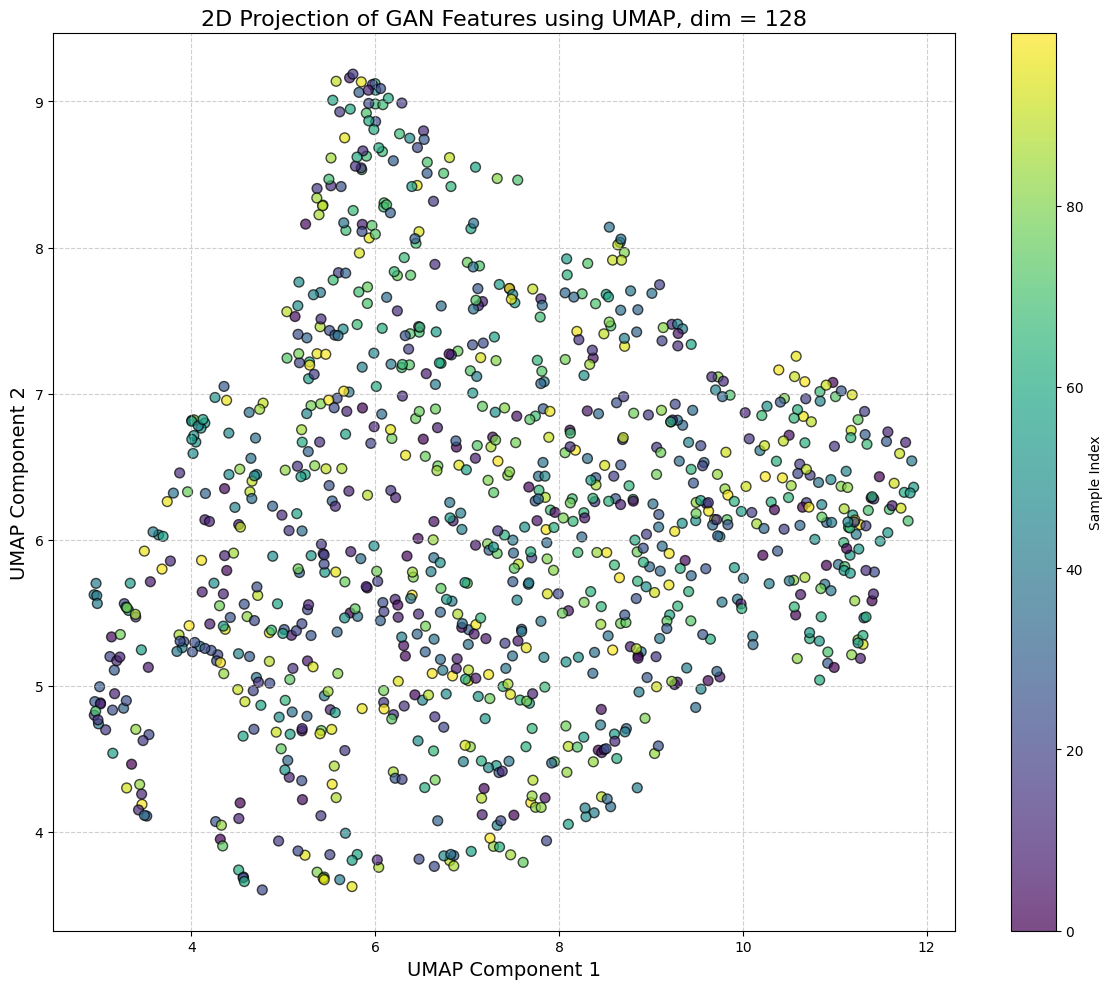

In [ ]:
n_samples = len(features_array)

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
features_2d = reducer.fit_transform(features_array)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_array, cmap='viridis', alpha=0.7, edgecolor='k', s=50)
plt.colorbar(scatter, label='Sample Index')
plt.title('2D Projection of GAN Features using UMAP, dim = 128', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=14)
plt.ylabel('UMAP Component 2', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('umap_projection.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
np.save('features-cifar-100', features_array)

In [ ]:
np.save('labels-cifar-100', labels_array)

## **Small Net training**

Training a simple two-layer neural network on features obtained from a generative GAN model. Analyzing model accuracy based on varying the number of images per class.

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes, hidden_dim=128):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        self.input_size = input_size
        self.num_classes = num_classes

    def forward(self, x):
        return self.model(x)

In [ ]:
def extract_features(images, labels, encoder):
    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        features = encoder(images)
    return features


def train_model(train_loader, model, criterion, optimizer, encoder, epochs=90, loss_list=[]):
    model.train()
    loss_list = []
    for epoch in tqdm(range(1, epochs+1)):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images, labels, encoder)
            outputs = model(features)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
        print(f"Epoch {epoch}, Loss: {running_loss / len(train_loader):.3f}")
        '''if epoch % 10 == 0:
            accuracy = test_model(model, test_loader, encoder)
            print(f"Accuracy {accuracy}%")'''
    return loss_list


def test_model(model, test_loader, encoder):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            features = torch.tensor(extract_features(images, labels, encoder)).to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
n_classes = 100
batch_size = 4
input_size = 128
hidden_size = 32
n_samples = 16

In [ ]:
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)

class_indices = [[] for _ in range(n_classes)]
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

selected_indices = []
for indices in class_indices:
    selected_indices.extend(indices[:n_samples])

sampler = SubsetRandomSampler(selected_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
accuracies = {}

In [ ]:
epochs_all = [200, 200, 200, 200, 200, 100, 100, 100]
dataset_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
batch_sizes = [4, 4, 4, 8, 8, 16, 32, 64, 64, 64, 128]

for dataset_size, epochs in zip(dataset_sizes, epochs_all):
    print(f'--------- CALCULATIONS FOR dataset_size={dataset_size} ---------')

    selected_indices = []
    for indices in class_indices:
        selected_indices.extend(indices[:dataset_size])

    sampler = SubsetRandomSampler(selected_indices)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

    model = Net(input_size, n_classes, hidden_dim=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_list = train_model(train_loader, model, criterion, optimizer, encoder, epochs=epochs)
    accuracy = test_model(model, test_loader, encoder)

    print(f'accuracy = {accuracy}%')
    accuracies[dataset_size] = accuracy

--------- CALCULATIONS FOR dataset_size=2 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 4.634
Epoch 2, Loss: 4.597
Epoch 3, Loss: 4.573
Epoch 4, Loss: 4.529
Epoch 5, Loss: 4.466
Epoch 6, Loss: 4.392
Epoch 7, Loss: 4.316
Epoch 8, Loss: 4.233
Epoch 9, Loss: 4.156
Epoch 10, Loss: 4.072
Epoch 11, Loss: 3.989
Epoch 12, Loss: 3.911
Epoch 13, Loss: 3.830
Epoch 14, Loss: 3.759
Epoch 15, Loss: 3.684
Epoch 16, Loss: 3.611
Epoch 17, Loss: 3.538
Epoch 18, Loss: 3.474
Epoch 19, Loss: 3.416
Epoch 20, Loss: 3.344
Epoch 21, Loss: 3.272
Epoch 22, Loss: 3.222
Epoch 23, Loss: 3.171
Epoch 24, Loss: 3.100
Epoch 25, Loss: 3.055
Epoch 26, Loss: 2.998
Epoch 27, Loss: 2.948
Epoch 28, Loss: 2.894
Epoch 29, Loss: 2.835
Epoch 30, Loss: 2.803
Epoch 31, Loss: 2.749
Epoch 32, Loss: 2.701
Epoch 33, Loss: 2.661
Epoch 34, Loss: 2.626
Epoch 35, Loss: 2.583
Epoch 36, Loss: 2.536
Epoch 37, Loss: 2.497
Epoch 38, Loss: 2.461
Epoch 39, Loss: 2.425
Epoch 40, Loss: 2.381
Epoch 41, Loss: 2.346
Epoch 42, Loss: 2.317
Epoch 43, Loss: 2.289
Epoch 44, Loss: 2.224
Epoch 45, Loss: 2.226
Epoch 46, Loss: 2.1

  0%|          | 0/2500 [00:00<?, ?it/s]

<ipython-input-29-3515c6ecc82a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(extract_features(images, labels, encoder)).to(device)


accuracy = 5.75%
--------- CALCULATIONS FOR dataset_size=4 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 4.628
Epoch 2, Loss: 4.602
Epoch 3, Loss: 4.577
Epoch 4, Loss: 4.545
Epoch 5, Loss: 4.500
Epoch 6, Loss: 4.453
Epoch 7, Loss: 4.402
Epoch 8, Loss: 4.344
Epoch 9, Loss: 4.287
Epoch 10, Loss: 4.230
Epoch 11, Loss: 4.171
Epoch 12, Loss: 4.111
Epoch 13, Loss: 4.054
Epoch 14, Loss: 3.997
Epoch 15, Loss: 3.936
Epoch 16, Loss: 3.878
Epoch 17, Loss: 3.836
Epoch 18, Loss: 3.773
Epoch 19, Loss: 3.726
Epoch 20, Loss: 3.683
Epoch 21, Loss: 3.639
Epoch 22, Loss: 3.592
Epoch 23, Loss: 3.552
Epoch 24, Loss: 3.511
Epoch 25, Loss: 3.476
Epoch 26, Loss: 3.440
Epoch 27, Loss: 3.400
Epoch 28, Loss: 3.365
Epoch 29, Loss: 3.337
Epoch 30, Loss: 3.314
Epoch 31, Loss: 3.278
Epoch 32, Loss: 3.242
Epoch 33, Loss: 3.211
Epoch 34, Loss: 3.180
Epoch 35, Loss: 3.156
Epoch 36, Loss: 3.139
Epoch 37, Loss: 3.120
Epoch 38, Loss: 3.091
Epoch 39, Loss: 3.051
Epoch 40, Loss: 3.032
Epoch 41, Loss: 3.019
Epoch 42, Loss: 2.987
Epoch 43, Loss: 2.970
Epoch 44, Loss: 2.946
Epoch 45, Loss: 2.932
Epoch 46, Loss: 2.8

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 6.78%
--------- CALCULATIONS FOR dataset_size=8 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 4.623
Epoch 2, Loss: 4.597
Epoch 3, Loss: 4.551
Epoch 4, Loss: 4.464
Epoch 5, Loss: 4.362
Epoch 6, Loss: 4.258
Epoch 7, Loss: 4.159
Epoch 8, Loss: 4.082
Epoch 9, Loss: 4.008
Epoch 10, Loss: 3.944
Epoch 11, Loss: 3.886
Epoch 12, Loss: 3.842
Epoch 13, Loss: 3.784
Epoch 14, Loss: 3.737
Epoch 15, Loss: 3.695
Epoch 16, Loss: 3.660
Epoch 17, Loss: 3.627
Epoch 18, Loss: 3.589
Epoch 19, Loss: 3.561
Epoch 20, Loss: 3.533
Epoch 21, Loss: 3.494
Epoch 22, Loss: 3.472
Epoch 23, Loss: 3.457
Epoch 24, Loss: 3.420
Epoch 25, Loss: 3.396
Epoch 26, Loss: 3.377
Epoch 27, Loss: 3.357
Epoch 28, Loss: 3.337
Epoch 29, Loss: 3.318
Epoch 30, Loss: 3.297
Epoch 31, Loss: 3.272
Epoch 32, Loss: 3.257
Epoch 33, Loss: 3.237
Epoch 34, Loss: 3.218
Epoch 35, Loss: 3.201
Epoch 36, Loss: 3.189
Epoch 37, Loss: 3.171
Epoch 38, Loss: 3.153
Epoch 39, Loss: 3.137
Epoch 40, Loss: 3.126
Epoch 41, Loss: 3.114
Epoch 42, Loss: 3.092
Epoch 43, Loss: 3.084
Epoch 44, Loss: 3.065
Epoch 45, Loss: 3.059
Epoch 46, Loss: 3.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 9.88%
--------- CALCULATIONS FOR dataset_size=16 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 4.612
Epoch 2, Loss: 4.554
Epoch 3, Loss: 4.428
Epoch 4, Loss: 4.283
Epoch 5, Loss: 4.161
Epoch 6, Loss: 4.058
Epoch 7, Loss: 3.984
Epoch 8, Loss: 3.911
Epoch 9, Loss: 3.853
Epoch 10, Loss: 3.803
Epoch 11, Loss: 3.755
Epoch 12, Loss: 3.712
Epoch 13, Loss: 3.675
Epoch 14, Loss: 3.629
Epoch 15, Loss: 3.602
Epoch 16, Loss: 3.572
Epoch 17, Loss: 3.543
Epoch 18, Loss: 3.511
Epoch 19, Loss: 3.484
Epoch 20, Loss: 3.460
Epoch 21, Loss: 3.442
Epoch 22, Loss: 3.419
Epoch 23, Loss: 3.400
Epoch 24, Loss: 3.380
Epoch 25, Loss: 3.358
Epoch 26, Loss: 3.340
Epoch 27, Loss: 3.328
Epoch 28, Loss: 3.313
Epoch 29, Loss: 3.294
Epoch 30, Loss: 3.277
Epoch 31, Loss: 3.263
Epoch 32, Loss: 3.242
Epoch 33, Loss: 3.240
Epoch 34, Loss: 3.223
Epoch 35, Loss: 3.208
Epoch 36, Loss: 3.191
Epoch 37, Loss: 3.185
Epoch 38, Loss: 3.170
Epoch 39, Loss: 3.156
Epoch 40, Loss: 3.140
Epoch 41, Loss: 3.134
Epoch 42, Loss: 3.119
Epoch 43, Loss: 3.114
Epoch 44, Loss: 3.104
Epoch 45, Loss: 3.085
Epoch 46, Loss: 3.0

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 14.32%
--------- CALCULATIONS FOR dataset_size=32 ---------


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1, Loss: 4.594
Epoch 2, Loss: 4.373
Epoch 3, Loss: 4.135
Epoch 4, Loss: 3.994
Epoch 5, Loss: 3.887
Epoch 6, Loss: 3.801
Epoch 7, Loss: 3.731
Epoch 8, Loss: 3.671
Epoch 9, Loss: 3.624
Epoch 10, Loss: 3.574
Epoch 11, Loss: 3.533
Epoch 12, Loss: 3.502
Epoch 13, Loss: 3.476
Epoch 14, Loss: 3.451
Epoch 15, Loss: 3.425
Epoch 16, Loss: 3.404
Epoch 17, Loss: 3.378
Epoch 18, Loss: 3.363
Epoch 19, Loss: 3.342
Epoch 20, Loss: 3.323
Epoch 21, Loss: 3.307
Epoch 22, Loss: 3.293
Epoch 23, Loss: 3.274
Epoch 24, Loss: 3.263
Epoch 25, Loss: 3.247
Epoch 26, Loss: 3.228
Epoch 27, Loss: 3.209
Epoch 28, Loss: 3.195
Epoch 29, Loss: 3.189
Epoch 30, Loss: 3.161
Epoch 31, Loss: 3.156
Epoch 32, Loss: 3.143
Epoch 33, Loss: 3.127
Epoch 34, Loss: 3.114
Epoch 35, Loss: 3.101
Epoch 36, Loss: 3.090
Epoch 37, Loss: 3.076
Epoch 38, Loss: 3.071
Epoch 39, Loss: 3.062
Epoch 40, Loss: 3.045
Epoch 41, Loss: 3.036
Epoch 42, Loss: 3.023
Epoch 43, Loss: 3.018
Epoch 44, Loss: 3.003
Epoch 45, Loss: 2.989
Epoch 46, Loss: 2.9

  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 18.85%
--------- CALCULATIONS FOR dataset_size=64 ---------


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1, Loss: 4.462
Epoch 2, Loss: 4.077
Epoch 3, Loss: 3.881
Epoch 4, Loss: 3.762
Epoch 5, Loss: 3.684
Epoch 6, Loss: 3.623
Epoch 7, Loss: 3.578
Epoch 8, Loss: 3.540
Epoch 9, Loss: 3.501


KeyboardInterrupt: 

In [ ]:
accuracies

{2: 5.75, 4: 6.78, 8: 9.88, 16: 14.32, 32: 18.85}

In [ ]:
epochs_all = [50, 30, 20]
dataset_sizes = [64, 128, 256]
batch_sizes = [32, 32, 64]

for dataset_size, epochs in zip(dataset_sizes, epochs_all):
    print(f'--------- CALCULATIONS FOR dataset_size={dataset_size} ---------')

    selected_indices = []
    for indices in class_indices:
        selected_indices.extend(indices[:dataset_size])

    sampler = SubsetRandomSampler(selected_indices)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

    model = Net(input_size, n_classes, hidden_dim=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_list = train_model(train_loader, model, criterion, optimizer, encoder, epochs=epochs)
    accuracy = test_model(model, test_loader, encoder)

    print(f'accuracy = {accuracy}%')
    accuracies[dataset_size] = accuracy

--------- CALCULATIONS FOR dataset_size=64 ---------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 4.496
Epoch 2, Loss: 4.138
Epoch 3, Loss: 3.944
Epoch 4, Loss: 3.826
Epoch 5, Loss: 3.744
Epoch 6, Loss: 3.687
Epoch 7, Loss: 3.626
Epoch 8, Loss: 3.584
Epoch 9, Loss: 3.548
Epoch 10, Loss: 3.520
Epoch 11, Loss: 3.488
Epoch 12, Loss: 3.466
Epoch 13, Loss: 3.439
Epoch 14, Loss: 3.417
Epoch 15, Loss: 3.398
Epoch 16, Loss: 3.380
Epoch 17, Loss: 3.363
Epoch 18, Loss: 3.337
Epoch 19, Loss: 3.320
Epoch 20, Loss: 3.302
Epoch 21, Loss: 3.292
Epoch 22, Loss: 3.271
Epoch 23, Loss: 3.261
Epoch 24, Loss: 3.241
Epoch 25, Loss: 3.232
Epoch 26, Loss: 3.217
Epoch 27, Loss: 3.202
Epoch 28, Loss: 3.193
Epoch 29, Loss: 3.183
Epoch 30, Loss: 3.169
Epoch 31, Loss: 3.161
Epoch 32, Loss: 3.147
Epoch 33, Loss: 3.140
Epoch 34, Loss: 3.129
Epoch 35, Loss: 3.122
Epoch 36, Loss: 3.112
Epoch 37, Loss: 3.106
Epoch 38, Loss: 3.093
Epoch 39, Loss: 3.091
Epoch 40, Loss: 3.081
Epoch 41, Loss: 3.079
Epoch 42, Loss: 3.067
Epoch 43, Loss: 3.062
Epoch 44, Loss: 3.055
Epoch 45, Loss: 3.053
Epoch 46, Loss: 3.0

  0%|          | 0/2500 [00:00<?, ?it/s]

<ipython-input-29-3515c6ecc82a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(extract_features(images, labels, encoder)).to(device)


accuracy = 19.37%
--------- CALCULATIONS FOR dataset_size=128 ---------


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, Loss: 4.378
Epoch 2, Loss: 4.015
Epoch 3, Loss: 3.842
Epoch 4, Loss: 3.737
Epoch 5, Loss: 3.671
Epoch 6, Loss: 3.622
Epoch 7, Loss: 3.585
Epoch 8, Loss: 3.553
Epoch 9, Loss: 3.522
Epoch 10, Loss: 3.496
Epoch 11, Loss: 3.473
Epoch 12, Loss: 3.448
Epoch 13, Loss: 3.428
Epoch 14, Loss: 3.410
Epoch 15, Loss: 3.394
Epoch 16, Loss: 3.379
Epoch 17, Loss: 3.366
Epoch 18, Loss: 3.352
Epoch 19, Loss: 3.339
Epoch 20, Loss: 3.329
Epoch 21, Loss: 3.319
Epoch 22, Loss: 3.309
Epoch 23, Loss: 3.301
Epoch 24, Loss: 3.292
Epoch 25, Loss: 3.287
Epoch 26, Loss: 3.279
Epoch 27, Loss: 3.271
Epoch 28, Loss: 3.266
Epoch 29, Loss: 3.258
Epoch 30, Loss: 3.251


  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 18.22%
--------- CALCULATIONS FOR dataset_size=256 ---------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.098
Epoch 2, Loss: 3.695
Epoch 3, Loss: 3.560
Epoch 4, Loss: 3.462
Epoch 5, Loss: 3.384
Epoch 6, Loss: 3.322
Epoch 7, Loss: 3.269
Epoch 8, Loss: 3.230
Epoch 9, Loss: 3.198
Epoch 10, Loss: 3.171
Epoch 11, Loss: 3.149
Epoch 12, Loss: 3.133
Epoch 13, Loss: 3.116
Epoch 14, Loss: 3.103
Epoch 15, Loss: 3.088
Epoch 16, Loss: 3.079
Epoch 17, Loss: 3.067
Epoch 18, Loss: 3.058
Epoch 19, Loss: 3.047
Epoch 20, Loss: 3.041


  0%|          | 0/2500 [00:00<?, ?it/s]

accuracy = 23.48%


In [ ]:
accuracies

{2: 5.75,
 4: 6.78,
 8: 9.88,
 16: 14.32,
 32: 18.85,
 64: 19.37,
 128: 18.22,
 256: 23.48}